In [2]:
%load_ext Cython
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [295]:
%%cython
cimport cython

import numpy as np
cimport numpy as np
import networkx as nx

cpdef tuple initialize_lattice(int L, int states):
    '''Inititalizes a lattice graph including states and an adjency matrix'''
    # initialize matrix s.t. an adjency matrix can be made
    G = nx.grid_2d_graph(L,L)
    cdef int length = len(G.nodes())
    
    # assign random state to each node and put in array
    cdef np.ndarray G2 = np.random.randint(low=0, high=states, size=length)
#     cdef np.ndarray G2 = np.array((np.random.randint(low=0, high=states, size=length), np.random.random(size=length)))
    cdef np.ndarray A = nx.adjacency_matrix(G).todense()
    
    return G2, A

cdef np.ndarray neighbors(A, node):
    '''Return an numpy array containing the neighbors of a node'''
    cdef np.ndarray nb = np.where(A[node]==1)[1]
    return nb

cdef np.ndarray init_J(int states):
    '''Interaction matrix initialization'''
    cdef np.ndarray J
    
    if states == 2: # A <-> A , B <-> B
        J = np.array([[1, 0],\
                      [0, 1]])
        
    elif states == 3: # A <-> B <-> C
        J = np.array([[0, 1, 0],\
                      [1, 0, 1],\
                      [0, 1, 0]])
        
    elif states == 4: # A <-> B <-> C <-> D
        J = np.array([[0, 1, 0, 0],\
                      [1, 0, 1, 0],\
                      [0, 1, 0, 1],\
                      [0, 0, 1, 0]])
    return J

cdef float hamiltonian(G, int node, np.ndarray nb, np.ndarray J):
    '''
    Hamiltonian function: Calculate the energy for each bond of a single node
    , return the sum of these energies

    H: Hamiltonian
    cur_node: investigated current node
    cur_nb: investigated current neighbor
    kronecker (not used): 1 if two nodes are in same state
    '''
    cdef float H = 0
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int kronecker
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        kronecker = 0
        
        # check if states are the same
        if cur_node == cur_nb:
            kronecker = 1
#         H += -1 * (1 - kronecker) #J[cur_node, cur_nb]) # * V[]
#         H -= 1 * (1 - J[cur_node, cur_nb]) # * V[]
        H -= J[cur_node, cur_nb]
    return H
    
cdef metropolis(G, A, J, int states, float beta, int time, float system_hamiltonian):
    '''
    Performs all metropolis algorithm steps.
    
    Difference in energy is - (H2 (new state) - H1 (old state)) .
    System hamiltonian and magnetization is changed.
    TODO: Check system magnetization 
    '''
    cdef int rand_node
    cdef int spin
    cdef float dE = 0
    cdef int rand_state
    cdef float p
    cdef float H1 
    cdef float H2
    cdef list sh = []
    cdef list fm = []

    fm.append(G.mean())
    for t in range(time):    
        for i in range(len(G)):
            # pick random node
            rand_node = np.random.randint(len(G)-1)
            spin = G[rand_node]
            
            rand_state = np.random.randint(states)
            while rand_state == spin:
                rand_state = np.random.randint(states)
            
            # calculate hamiltonian for current configuration
            nb = neighbors(A, rand_node)
            H1 = hamiltonian(G, rand_node, nb, J)
            
            # calculate hamiltonian for new configuration
            G_copy = G.copy()
            G_copy[rand_node] = rand_state
            H2 = hamiltonian(G_copy, rand_node, nb, J)

            # calculate energy difference
            dE = (H2 - H1)
                        
            # energy may always be decreased
            if dE <= 0:
                p = 1   
                
            # probability proportional to Boltzmann distribution.
            else: 
                p = np.exp(-beta*dE)
                
            # energy is increased with probability
            if np.random.random() <= p:
                G[rand_node] = rand_state
                system_hamiltonian += dE
                
            # change configuration back to the original
            else: 
                G[rand_node] = spin
    
            sh.append(system_hamiltonian)
            fm.append(G.mean())

    return G, sh, fm

cdef float full_hamiltonian(G, A, J):
    '''
    Returns the energy state of the system.
    '''
    cdef float system_hamiltonian = 0 
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_hamiltonian += hamiltonian(G, G[i], nb, J) 
    return 0.5 * system_hamiltonian

cdef float full_magnetization(G, A, J):
    '''
    TODO
    Returns magnetization state of the system.
    '''
    cdef float magnetisation = 0
    for i in range(len(G)):
        magnetisation += G[i]
    
    magnetisation = magnetisation / len(G)
    return magnetisation

def simulate(T, states):
    G, A = initialize_lattice(12, states)
    G_init = G.copy()
    J = init_J(states)    
    sh = full_hamiltonian(G,A,J)        
    beta = 1 / T# * (138064852 * 10**-23)
    timesteps = 100
    M, system_hamiltonian, fm = metropolis(G, A, J, states, beta, timesteps, sh)
    print(full_hamiltonian(M, A, J))
    return G_init, M, system_hamiltonian, J, fm

def test():
    G, A = initialize_lattice(3, 3)
    G_init = G.copy()
    J = init_J(3) 
    print(G_init.reshape(3,3))
    print(full_hamiltonian(G_init,A,J)) 

-240.0
1.0833333333333333


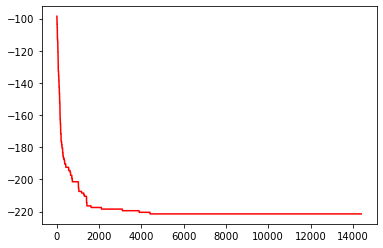

In [303]:
G_init, M, system_hamiltonian, J, fm = simulate(0.01, 3)
t = np.arange(0, len(system_hamiltonian))
# plt.plot(t, sh2, color='blue')
plt.plot(system_hamiltonian, color='red')
print(fm[-1])

In [304]:
G_init.reshape(12,12)

array([[0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 1, 0],
       [1, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1],
       [1, 1, 0, 1, 0, 2, 1, 1, 2, 2, 2, 1],
       [0, 1, 1, 1, 2, 2, 1, 0, 2, 0, 1, 2],
       [0, 2, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1],
       [2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 0],
       [2, 2, 1, 2, 0, 2, 0, 1, 1, 0, 2, 0],
       [1, 1, 1, 2, 0, 1, 1, 1, 0, 2, 0, 2],
       [2, 1, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0],
       [0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1],
       [2, 0, 2, 2, 1, 1, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 1, 2]])

In [305]:
M.reshape(12,12)

array([[0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1],
       [1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1, 2],
       [0, 1, 2, 1, 0, 1, 2, 1, 2, 1, 2, 1],
       [1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2],
       [2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 1],
       [1, 2, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2],
       [0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1],
       [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
       [0, 1, 0, 1, 2, 1, 2, 1, 2, 1, 2, 1],
       [0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 2, 1],
       [1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2]])

In [217]:
#plt.imshow(M.reshape(12,12))

In [238]:
temperatures = np.linspace(0.01, 50, 10) #[0.1, 1, 2, 4, 10]
temperatures = np.logspace(0.01, 10, 10)
states = [3]
runs = np.arange(0, 10, 1)

info_runs = np.zeros((len(states)*len(temperatures), 2))
avg_runs = np.zeros((len(runs)*len(states)*len(temperatures), 14400))
vc_satisfaction = np.zeros((len(runs)*len(states)*len(temperatures), 144))


def perform_tests(temperatures, states):
    '''
    Perform multiple simulations with different temperatures and states.
    Saves the system-hamiltonian per step of multiple runs.
    '''
    i = 0
    j = 0
    for state in states:
        print(state)
        for temp in temperatures:
            info_runs[j] = state, temp 
            j += 1
            for run in runs:
                G_init, M, system_hamiltonian, J, fm = simulate(temp, state)    
                avg_runs[i] = system_hamiltonian
                vc_satisfaction[i] = M
                i += 1
    return info_runs, avg_runs

info_runs, avg_runs = perform_tests(temperatures, states)

3


In [239]:
avg = np.zeros((avg_runs.shape[1]))
std = np.zeros((avg_runs.shape[1]))
minm = np.zeros((avg_runs.shape[1]))
maxm = np.zeros((avg_runs.shape[1]))

i = 0
start = 0
stop = runs.shape[0]

list_of_avg_end = []
plot = False

for k in range(len(states)*len(temperatures)):
    for i in range(avg_runs.shape[1]):
        avg[i] = np.mean(avg_runs[start:stop, i])
        std[i] = np.std(avg_runs[start:stop, i])
        minm[i] = np.amin(avg_runs[start:stop, i])
        maxm[i] = np.amax(avg_runs[start:stop, i])

    x = np.arange(0, avg_runs.shape[1])
    y = avg
    list_of_avg_end.append([info_runs[k][0], info_runs[k][1], avg[-1]])
    
    if plot == True:
        plt.plot(x,y, 'k-')
        plt.fill_between(x, y+std, y-std)
        plt.xlabel('timestep')
        plt.ylabel('sum of bond energies')
        plt.title('Temperature = '+ str(info_runs[k][1]) +' States = '+ str(info_runs[k][0]))
        plt.savefig('/home/thomas/Thesis/code/Potts/experiments/Hamiltonian plot, T=' + str(info_runs[k][1]) + 'states='+ str(info_runs[k][0]) +'.png', dpi=100)
        plt.show()
    
    start = stop + 1
    stop = stop + runs.shape[0]

In [240]:
temp2 = []
last2 = []
temp3 = []
last3 = []
temp4 = []
last4 = []

for i in list_of_avg_end:
    if i[0] == 2:
        last2.append(i[2])
        temp2.append(i[1])
        
    if i[0] == 3:
        last3.append(i[2])
        temp3.append(i[1])
        
    if i[0] == 4:
        last4.append(i[2])
        temp4.append(i[1])

Text(0, 0.5, 'Sum of bond energies')

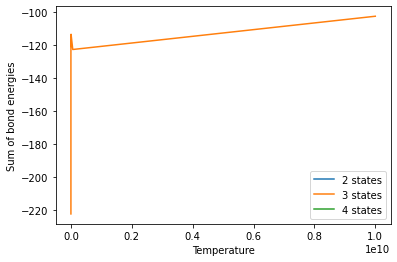

In [241]:
plt.plot(temp2, last2, label='2 states')
plt.plot(temp3, last3, label='3 states')
plt.plot(temp4, last4, label='4 states')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Sum of bond energies')

In [231]:
# unused code for plotting
if plot == True:
    # save 3 figures
    fig, axs = plt.subplots(2)
    fig.suptitle('T={}, states={}'.format(temp, state))
    pos = axs[0].imshow(G_init.reshape(12, 12), cmap='Blues')
    fig.colorbar(pos)
    pos = axs[1].imshow(M.reshape(12,12), cmap='Blues')
    fig.colorbar(pos)
    plt.savefig('/home/thomas/Thesis/code/Potts/experiments/T=' + str(temp) + 'states='+ str(state) +'.png', dpi=100)
#             plt.show()

    fig, axs = plt.subplots(1)
    fig.suptitle('T={}, states={}'.format(temp, state))
    axs.plot(t, system_hamiltonian)
    plt.savefig('/home/thomas/Thesis/code/Potts/experiments/Hamiltonian plot, T=' + str(temp) + 'states='+ str(state) +'.png', dpi=100)
#             plt.show()